Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Pretrain Step  0
Iter: 0; D loss: 0.07019; G_loss: -0.04302


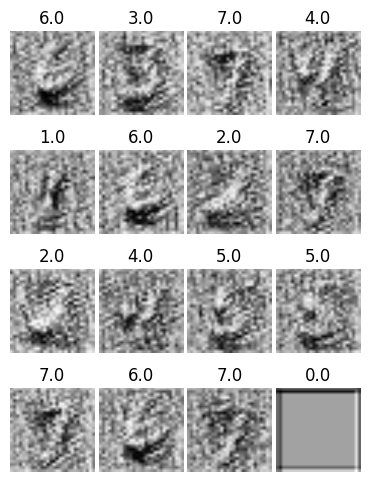

Iter: 100; D loss: 1.35; G_loss: -0.006316
Iter: 200; D loss: 1.374; G_loss: -0.003177
Iter: 300; D loss: 1.377; G_loss: -0.002481
Iter: 400; D loss: 1.378; G_loss: -0.001526
Iter: 500; D loss: 1.38; G_loss: -0.002138
Iter: 600; D loss: 1.369; G_loss: -0.001409
Iter: 700; D loss: 1.339; G_loss: -0.005178
Iter: 800; D loss: 1.367; G_loss: -0.002856
Iter: 900; D loss: 1.353; G_loss: -0.003875
Iter: 1000; D loss: 1.339; G_loss: -0.01043


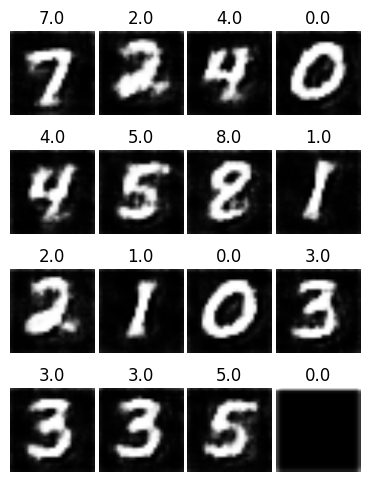

Iter: 1100; D loss: 1.262; G_loss: -0.005773
Iter: 1200; D loss: 1.255; G_loss: -0.03363
Iter: 1300; D loss: 1.245; G_loss: -0.008773
Iter: 1400; D loss: 1.225; G_loss: -0.003256
Iter: 1500; D loss: 1.214; G_loss: -0.04109
Iter: 1600; D loss: 1.235; G_loss: -0.02212
Iter: 1700; D loss: 1.235; G_loss: -0.00193
Iter: 1800; D loss: 1.235; G_loss: -0.0135
Iter: 1900; D loss: 1.234; G_loss: -0.01255
Iter: 2000; D loss: 1.226; G_loss: -0.001413


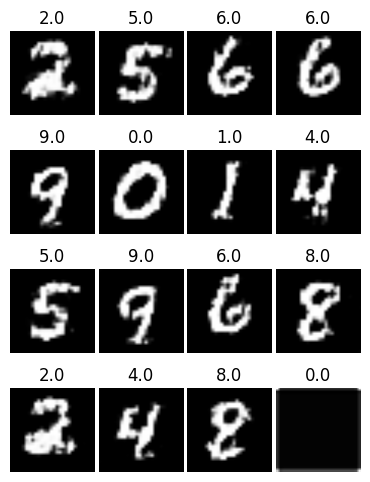

Iter: 2100; D loss: 1.246; G_loss: -0.01057


KeyboardInterrupt: 

In [1]:
%matplotlib inline
from skimage import io
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os


batch_size = 32 #batch size
input_dim = 784 #dim x and z input_size

#mnist data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
X_train = mnist.train.images
Y_train = mnist.train.labels
X_train = X_train.reshape(55000,28,28,1)

#reorganize labels
y_train = np.zeros(55000)
for i in range(len(Y_train)):
    y_train[i]= np.argwhere(Y_train[i]==1)#reshape

#create mean Images
numberImages = np.zeros((10,28,28,1))
for i in range(10):
    numbers = np.argwhere(y_train==i)
    z = X_train[numbers] #collect all images with number    
    numberImages[i] = np.mean(z, axis=0)

X_train = X_train.reshape(55000,784)


#simple plot function
def plot(samples, labels):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    plt.subplots_adjust(left=None, bottom=None, right=1, top=1.3,
                wspace=None, hspace=None)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.title(labels[i])
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')   
    return fig


#sample for Generator: Random Mean Images 0-9 + Uniform Noise Vector + Label
def sample_z(batch_size):
    batch = np.zeros((batch_size,input_dim))
    labels = np.zeros((batch_size,))
    for i in range(batch_size-1):
        vector = np.random.uniform(-1., 1., size=[input_dim])/7
        index = int(np.random.rand(1)*10)
        number = np.reshape(numberImages[index],784)
        z_im = number+vector
        batch[i]=z_im
        labels[i]=index
    return (batch,labels)


#Two Versions of Generator-Discriminator
#Variables V2 -Generator
kernel_G1 = tf.Variable(tf.truncated_normal([3, 3, 1, 64], dtype=tf.float32,
                                               stddev=1e-1), name='kernel_G1')
biases_G1 = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                   trainable=True, name='biases_G1')

kernel_G2 = tf.Variable(tf.truncated_normal([3, 3, 64, 32], dtype=tf.float32,
                                               stddev=1e-1), name='kernel_G2')
biases_G2 = tf.Variable(tf.constant(0.0, shape=[32], dtype=tf.float32),
                   trainable=True, name='biases_G2')

kernel_G3 = tf.Variable(tf.truncated_normal([3, 3, 32, 1], dtype=tf.float32,
                                               stddev=1e-1), name='kernel_G3')
biases_G3 = tf.Variable(tf.constant(0.0, shape=[1], dtype=tf.float32),
                   trainable=True, name='biases_G3')

theta_G2 = [kernel_G1,biases_G1,kernel_G2,biases_G2,kernel_G3,biases_G3]

#Discriminator
kernel_D1 = tf.Variable(tf.truncated_normal([3, 3, 1, 64], dtype=tf.float32,
                                               stddev=1e-1), name='kernel_D1')
biases_D1 = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                   trainable=True, name='biases_D1')

kernel_D2 = tf.Variable(tf.truncated_normal([3, 3, 64, 32], dtype=tf.float32,
                                               stddev=1e-1), name='kernel_D2')
biases_D2 = tf.Variable(tf.constant(0.0, shape=[32], dtype=tf.float32),
                   trainable=True, name='biases_D2')

kernel_D3 = tf.Variable(tf.truncated_normal([3, 3, 32, 16], dtype=tf.float32,
                                               stddev=1e-1), name='kernel_D3')
biases_D3 = tf.Variable(tf.constant(0.0, shape=[16], dtype=tf.float32),
                   trainable=True, name='biases_D3')

theta_D2 = [kernel_D1,biases_D1,kernel_D2,biases_D2,kernel_D3,biases_D3]
'''

def generator(z):
    with tf.variable_scope('generator'):
        z = tf.reshape(z,[-1,28,28,1])
        net = slim.conv2d(z, 64, [3, 3], weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                          scope='convG_1',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        net = slim.conv2d(net, 32, [3, 3], weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                          scope='convG_2',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        #net = slim.conv2d(net, 16, [3, 3],weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
        #                  scope='convG_3',padding = 'SAME')
        #net = slim.batch_norm(net)
        #net = tf.nn.relu(net)
        net = slim.conv2d(net, 1, [1,1],weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                          scope='convG_4',padding = 'SAME')
        G_prob = tf.nn.sigmoid(net)
        return G_prob
'''
def generator2(z):
    z = tf.reshape(z,[-1,28,28,1])
    with tf.name_scope('convG_1') as scope:
        conv_G1 = tf.nn.conv2d(z, kernel_G1, [1, 1, 1, 1], padding='SAME')
        in_G1 = tf.nn.bias_add(conv_G1, biases_G1)
        in_G1 = slim.batch_norm(in_G1)
        conv1 = tf.nn.relu(in_G1, name=scope)
    with tf.name_scope('convG_2') as scope:
        conv_G2 = tf.nn.conv2d(conv1, kernel_G2, [1, 1, 1, 1], padding='SAME')
        in_G2 = tf.nn.bias_add(conv_G2, biases_G2)
        in_G2 = slim.batch_norm(in_G2)
        conv2 = tf.nn.relu(in_G2, name=scope)
    with tf.name_scope('convG_3') as scope:
        conv_G3 = tf.nn.conv2d(conv2, kernel_G3, [1, 1, 1, 1], padding='SAME')
        in_G3 = tf.nn.bias_add(conv_G3, biases_G3)
    return tf.nn.sigmoid(in_G3)
'''

def discriminator(x):
    with tf.variable_scope('discriminator'):
        x = tf.reshape(x,[-1,28,28,1])
        #net = slim.conv2d(x, 128, [3, 3], weights_initializer=tf.contrib.layers.xavier_initializer(), scope='convD_1')
        #net = slim.batch_norm(net)
        #net = tf.nn.relu(net)
        net = slim.conv2d(x, 64, [3, 3],weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                          scope='convD_2',padding = 'SAME')
        net = tf.nn.relu(net)
        net = slim.conv2d(net, 32, [3, 3],weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                          scope='convD_3',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        net = slim.conv2d(net, 16, [1,1],weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                          scope='convD_4',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        return slim.fully_connected(net, num_outputs = 1,weights_initializer=tf.truncated_normal_initializer(stddev=1e-1))
'''
def discriminator2(x):
    x = tf.reshape(x,[-1,28,28,1])
    with tf.name_scope('convD_1') as scope:
        conv_D1 = tf.nn.conv2d(x, kernel_D1, [1, 1, 1, 1], padding='SAME')
        in_D1 = tf.nn.bias_add(conv_D1, biases_D1)
        conv1 = tf.nn.relu(in_D1, name=scope)
    with tf.name_scope('convD_2') as scope:
        conv_D2 = tf.nn.conv2d(conv1, kernel_D2, [1, 1, 1, 1], padding='SAME')
        in_D2 = tf.nn.bias_add(conv_D2, biases_D2)
        in_D2 = slim.batch_norm(in_D2)
        conv2 = tf.nn.relu(in_D2, name=scope)
    with tf.name_scope('convD_3') as scope:
        conv_D3 = tf.nn.conv2d(conv2, kernel_D3, [1, 1, 1, 1], padding='SAME')
        in_D3 = tf.nn.bias_add(conv_D3, biases_D3)
        in_D3 = slim.batch_norm(in_D3)
        conv3 = tf.nn.relu(in_D3, name=scope)
    return slim.fully_connected(conv3, 1)


#Session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)


#input
X = tf.placeholder(tf.float32, shape=[None, input_dim]) 
z = tf.placeholder(tf.float32, shape=[None, input_dim])

#Models
G_sample = generator2(z)
D_real = discriminator2(X)
D_fake = discriminator2(G_sample)

#variables V1
theta_D1 = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator') 
theta_G1 = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')



D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
G_loss = -tf.reduce_mean(D_fake)

D_solver = (tf.train.RMSPropOptimizer(learning_rate=1e-4)
            .minimize(-D_loss, var_list=theta_D2))
G_solver = (tf.train.RMSPropOptimizer(learning_rate=1e-4)
            .minimize(G_loss, var_list=theta_G2))

clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in theta_D2]


if not os.path.exists('out/'):
    os.makedirs('out/')

#initalize Variables    
sess.run(tf.global_variables_initializer())    
    
#pretrain disc:
for t in range(1):
    #train discriminator
    print("Pretrain Step ",t)
    Xdata, _ = mnist.train.next_batch(batch_size)
    (im, labels) = sample_z(batch_size) #get Image Batch+Labels
    _, D_loss_curr, _ = sess.run(
        [D_solver, D_loss, clip_D],
        feed_dict={X: Xdata, z: im}
    ) 
    
i = 0
for it in range(100000):
    for _ in range(5): #train discriminator
        Xdata, _ = mnist.train.next_batch(batch_size)
        (im, labels) = sample_z(batch_size) #get Image Batch+Labels
        _, D_loss_curr, _ = sess.run(
            [D_solver, D_loss, clip_D],
            feed_dict={X: Xdata, z: im}
        )
    (im, labels) = sample_z(batch_size) #get Image Batch+Labels
    _, G_loss_curr = sess.run(
        [G_solver, G_loss],
        feed_dict={z: im}
    )

    if it % 100 == 0:
        print('Iter: {}; D loss: {:.4}; G_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr))

        if it % 1000 == 0:
            (im, labels) = sample_z(16) #get Image Batch+Labels
            samples = sess.run(G_sample, feed_dict={z: im})
            fig = plot(samples, labels)
            plt.savefig('out/{}.png'
                        .format(str(i).zfill(3)), bbox_inches='tight')
            plt.show()
            i += 1
plt.close(fig)